# COLX 585 Trends in Computational Linguistic
##  Lab tutorial 2: BPE and BERT

## Introduction

Transfer learning, particularly models like [ELMO](https://allennlp.org/elmo), [Open-GPT](https://openai.com/blog/better-language-models/), and [BERT](https://github.com/google-research/bert) allows researchers to smash multiple benchmarks with minimal task-specific fine-tuning and provids the rest of the NLP community with pretrained models that could easily (with less data and less compute time) be fine-tuned and implemented to produce state of the art results.

BERT (Bidirectional Encoder Representations from Transformers), is an approach for language modeling that involves two self-supervised learning tasks, **(1) masked language models (MLM)** and **(2) next sentence predication (NSP)**. BERT is equipped with a Transformer based Encoder architecture which naturally conditions on **bi-directional context**. Google released their [pre-trained BERT models](https://github.com/google-research/bert#pre-trained-models), e.g., BERT-Large Uncased, BERT-Large Cased, and BERT-Base Multilingual Cased.
You can modify and fine-tune BERT to create a powerful model for your favorite NLP task that can give you state of the art results.

In this tutorial, we will fine-tune BERT on a classification task. Specifically, we will take the pre-trained BERT model, add an untrained linear layer on top of BERT, and train the new model for our classification task end-to-end. 

![](https://storage.googleapis.com/groundai-web-prod/media/users/user_14/project_381680/images/figures/bert.png)

Picture Courtesy: https://www.groundai.com/project/x-bert-extreme-multi-label-text-classification-with-bert/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


## Import require Python libraries

In [3]:
import tensorflow
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from tqdm import tqdm, trange
import pandas as pd
import numpy as np
import io
import os
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix
import matplotlib
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
## Set seed of randomization and working device
manual_seed = 77
torch.manual_seed(manual_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
n_gpu = torch.cuda.device_count()
if n_gpu > 0:
    torch.cuda.manual_seed(manual_seed)

print(torch.cuda.get_device_name(0))

cuda
Tesla T4


Colab doesn't install `transformers` library automatically. Hence, we should install `transformers` first.

In [5]:
! pip install transformers

     |████████████████████████████████| 552kB 8.9MB/s 
     |████████████████████████████████| 870kB 58.7MB/s 
     |████████████████████████████████| 3.7MB 55.6MB/s 
     |████████████████████████████████| 1.0MB 40.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=f6f792c34d987e77097f9f6c98a8a6ce8c8845a64c8b661ebc75bcd1c18d7bde
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
from transformers import *

`Transformers` provides [10+ transformer-based deep learning architectures](https://huggingface.co/transformers/pretrained_models.html) (including English, French). You can implement and load the checkpoints of these architectures using `Transformers` APIs. For each architecture, it provides several class for tokenization, pre-training, and fine-tuning.
Please learn more information [here](https://huggingface.co/transformers/index.html). 

In [0]:
# Transformers has a unified API
# here we list models for 10 transformer architectures
# for the full list of available pretrained-models: go to https://huggingface.co/transformers/pretrained_models.html
#          Model          | Tokenizer          | Pretrained weights shortcut
MODELS = [(BertModel,       BertTokenizer,       'bert-base-uncased'),
          (OpenAIGPTModel,  OpenAIGPTTokenizer,  'openai-gpt'),
          (GPT2Model,       GPT2Tokenizer,       'gpt2'),
          (CTRLModel,       CTRLTokenizer,       'ctrl'),
          (TransfoXLModel,  TransfoXLTokenizer,  'transfo-xl-wt103'),
          (XLNetModel,      XLNetTokenizer,      'xlnet-base-cased'),
          (XLMModel,        XLMTokenizer,        'xlm-mlm-enfr-1024'),
          (DistilBertModel, DistilBertTokenizer, 'distilbert-base-cased'),
          (RobertaModel,    RobertaTokenizer,    'roberta-base'),
          (XLMRobertaModel, XLMRobertaTokenizer, 'xlm-roberta-base'),
         ]
         
# Each architecture is provided with several class for fine-tuning on down-stream tasks, e.g.
BERT_MODEL_CLASSES = [BertModel, BertForPreTraining, BertForMaskedLM, BertForNextSentencePrediction,
                      BertForSequenceClassification, BertForTokenClassification, BertForQuestionAnswering]

## Data prepare

In this tutorial, we use the corpus from the [CL-Aff shared task](https://sites.google.com/view/affcon2019/cl-aff-shared-task?authuser=0). HappyDB is a dataset of about 100,000 `happy moments` crowd-sourced via Amazon’s Mechanical Turk where each worker was asked to describe in a complete sentence `what made them happy in the past 24 hours`. Each user was asked to describe three such moments. 
In this tutorial, we focus on `sociality classification`. Sociality refers to `whether or not other people than the author are involved in the emotion situation`. For example, an emotion experience with a sociality value "yes" (i.e., other people are involved) could teach us about social groups (e.g., families) and the range of emotions expressed during specific types of situations (e.g., wedding, death). 

We only use labelled dataset which include 10,560 labelled samples. 

We have already preprocessed (tokenization, removing URLs, mentions, hashtags and so on) the tweets and placed it under ``./happy_db`` folder in three files as ``train.tsv``, ``dev.tsv`` and ``test.tsv``. We split the labeled data into 80\% training set (8,448 moments) and 20\% development set (2112 moments).

First, we define a function to pre-process input data. 

In [0]:
# define a function for data preparation
def data_prepare(file_path, lab2ind, tokenizer, max_len = 32, mode = 'train'):
    '''
    file_path: the path to input file. 
                In train mode, the input must be a tsv file that includes two columns where the first is text, and second column is label.
                The first row must be header of columns.

                In predict mode, the input must be a tsv file that includes only one column where the first is text.
                The first row must be header of column.

    lab2ind: dictionary of label classes
    tokenizer: BERT tokenizer
    max_len: maximal length of input sequence
    mode: train or predict
    '''
    # if we are in train mode, we will load two columns (i.e., text and label).
    if mode == 'train':
        # Use pandas to load dataset
        df = pd.read_csv(file_path, delimiter='\t',header=0, names=['content','label'])
        print("Data size ", df.shape)
        labels = df.label.values
        
        # Create sentence and label lists
        labels = [lab2ind[i] for i in labels] 
        print("Label is ", labels[0])
        
        # Convert data into torch tensors
        labels = torch.tensor(labels)

    # if we are in predict mode, we will load one column (i.e., text).
    elif mode == 'predict':
        df = pd.read_csv(file_path, delimiter='\t',header=0, names=['content'])
        print("Data size ", df.shape)
        # create placeholder
        labels = []
    else:
        print("the type of mode should be either 'train' or 'predict'. ")
        return
        
    # Create sentence and label lists
    content = df.content.values

    # We need to add a special token at the beginning for BERT to work properly.
    content = ["[CLS] " + text for text in content]

    # Import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.
    tokenized_texts = [tokenizer.tokenize(text) for text in content]

    
    # if the sequence is longer the maximal length, we truncate it to the pre-defined maximal length
    tokenized_texts = [ text[:max_len+1] for text in tokenized_texts]

    # We also need to add a special token at the end.
    tokenized_texts = [ text+['[SEP]'] for text in tokenized_texts]
    print ("Tokenize the first sentence:\n",tokenized_texts[0])
    
    # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    print ("Index numbers of the first sentence:\n",input_ids[0])

    # Pad our input seqeunce to the fixed length (i.e., max_len) with index of [PAD] token
    pad_ind = tokenizer.convert_tokens_to_ids(['[PAD]'])[0]
    input_ids = pad_sequences(input_ids, maxlen=max_len+2, dtype="long", truncating="post", padding="post", value=pad_ind)
    print ("Index numbers of the first sentence after padding:\n",input_ids[0])

    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for pad tokens
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # Convert all of our data into torch tensors, the required datatype for our model
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, labels, masks

We use `BertTokenizer.from_pretrained()` to load vocabulary of pretrained model. The first argument should be either a string with the `shortcut name` of a pretrained model or a path to a directory containing model vocabulary file, `vocab.txt`. `Transformers` provides many pre-trained checkpoints with pre-defined `shortcut name`. If the argument is a correct model identifier listed on [here](https://huggingface.co/models), the model will download the vocabulary and load it to tokenizer automatically. If it doesn't match any model identifier, the model will use this argument as a path to load the vocabulary. 

We give "bert-large-uncased" as the first argument, which refers to the **24-layer, 1024-hidden, 16-heads, 340M parameters** [variant of BERT model](https://huggingface.co/transformers/pretrained_models.html). "bert-large-uncased" is a model identifier in `Transformers` so the vocabulary will be downloaded and applied to our tokenizer. The vocabulary of "bert-large-uncased" was generated using bype-pair encoding and includes 30,522 WordPieces.     

In [9]:
model_path = "bert-large-uncased"
# define label to number dictionary
lab2ind = {'no': 0, 'yes': 1}

# tokenizer from pre-trained BERT model
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased',do_lower_case=True)

In [10]:
# Use defined funtion to extract data
train_inputs, train_labels, train_masks = data_prepare("./drive/My Drive/Colab Notebooks/happy_db/train.tsv", lab2ind,tokenizer)
validation_inputs, validation_labels, validation_masks = data_prepare("./drive/My Drive/Colab Notebooks/happy_db/dev.tsv", lab2ind,tokenizer)

Data size  (8448, 2)
Label is  1
Tokenize the first sentence:
 ['[CLS]', 'it', 'was', 'my', 'birthday', ',', 'and', 'my', 'wife', 'and', 'daughter', 'surprised', 'me', 'with', 'some', 'surprise', 'guests', 'and', 'a', 'small', 'party', '.', '[SEP]']
Index numbers of the first sentence:
 [101, 2009, 2001, 2026, 5798, 1010, 1998, 2026, 2564, 1998, 2684, 4527, 2033, 2007, 2070, 4474, 6368, 1998, 1037, 2235, 2283, 1012, 102]
Index numbers of the first sentence after padding:
 [ 101 2009 2001 2026 5798 1010 1998 2026 2564 1998 2684 4527 2033 2007
 2070 4474 6368 1998 1037 2235 2283 1012  102    0    0    0    0    0
    0    0    0    0    0    0]
Data size  (1056, 2)
Label is  1
Tokenize the first sentence:
 ['[CLS]', 'my', 'baby', 'took', 'a', '1', '.', '5', 'hour', 'nap', 'instead', 'of', 'a', '20', '##min', '##ute', 'nap', 'and', 'i', 'was', 'able', 'to', 'get', 'some', 'things', 'done', '!', '[SEP]']
Index numbers of the first sentence:
 [101, 2026, 3336, 2165, 1037, 1015, 1012, 1019, 

In [11]:
train_inputs.shape

torch.Size([8448, 34])

Create an iterator of our data with `torch DataLoader`. This helps us to save on memory during training.

For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32. We use 32 batch size here. 



In [0]:
batch_size = 32
# We'll take training samples in random order in each epoch. 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, 
                              sampler = RandomSampler(train_data), # Select batches randomly
                              batch_size=batch_size)

# We'll just read validation set sequentially.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(validation_data, 
                                   sampler = SequentialSampler(validation_data), # Pull out batches sequentially.
                                   batch_size=batch_size)


## Loading pre-trained model

We use the [BertModel of Transformers](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertmodel) to load pretrained BERT model.

Use [`BertModel.from_pretrained()`](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.from_pretrained) to instantiate a model from a pretrained model configuration.

Same as `BertTokenizer.from_pretrained()`, if the argument is a correct model identifier listed on [here](https://huggingface.co/models), the model will download checkpoint and apply to model entity automatically. If it doesn't match any model identifier, the model will use this argument as a path to load checkpoint. 

The arguments `output_hidden_states` and `output_attention` are to indicate whether model returns full list of hidden-states and attentions weights of all layers. 

Here, we give "bert-large-uncased" as first argument. `Transformers` will download the checkpoint, and the weights will be used to initialize our model. The "bert-large-uncased" model contains 24-layer, 1024-hidden, 16-heads, 340M parameters.  

In [13]:
model_path = "bert-large-uncased"

bert_model = BertModel.from_pretrained(model_path, output_hidden_states=True, output_attentions=True).to(device)

Let's use the first batch as an example to explore BERT model.

In [0]:
dataiter = iter(train_dataloader)
batch = dataiter.next()
# Add batch to GPU
batch = tuple(t.to(device) for t in batch)
# Unpack the inputs from our dataloader
input_ids, input_mask, labels = batch

We set `output_hidden_states=True, output_attentions=True` so the output of `bert_model` will be 4 variables (i.e., `last_hidden_state, pooler_output, hidden_states, attentions`).

In [0]:
last_hidden_state, pooler_output, hidden_states, attentions = bert_model(input_ids, attention_mask = input_mask)

1. `last_hidden_state`: sequence of hidden-states at the output of the last layer.

In [16]:
last_hidden_state.shape # [batch size, seq length, hidden size]

torch.Size([32, 34, 1024])

2. `pooler_output`: last layer hidden-state of the first token of the sequence (classification token, `[CLS]`).

In [17]:
pooler_output.shape # [batch size, hidden size]

torch.Size([32, 1024])

3. `hidden_states`: list of `Tensor` (one for the output of each layer + the output of the embeddings) of shape `[batch_size, sequence_length, hidden_size]`: Hidden-states of the model at the output of each layer plus the initial embedding outputs. 

In [18]:
print(len(hidden_states))

25


Let's take a look at each item in this list.

In [19]:
for i, item in enumerate(hidden_states):
  print("layer " + str(i), item.shape) # [batch size, sequence length, hidden size]

layer 0 torch.Size([32, 34, 1024])
layer 1 torch.Size([32, 34, 1024])
layer 2 torch.Size([32, 34, 1024])
layer 3 torch.Size([32, 34, 1024])
layer 4 torch.Size([32, 34, 1024])
layer 5 torch.Size([32, 34, 1024])
layer 6 torch.Size([32, 34, 1024])
layer 7 torch.Size([32, 34, 1024])
layer 8 torch.Size([32, 34, 1024])
layer 9 torch.Size([32, 34, 1024])
layer 10 torch.Size([32, 34, 1024])
layer 11 torch.Size([32, 34, 1024])
layer 12 torch.Size([32, 34, 1024])
layer 13 torch.Size([32, 34, 1024])
layer 14 torch.Size([32, 34, 1024])
layer 15 torch.Size([32, 34, 1024])
layer 16 torch.Size([32, 34, 1024])
layer 17 torch.Size([32, 34, 1024])
layer 18 torch.Size([32, 34, 1024])
layer 19 torch.Size([32, 34, 1024])
layer 20 torch.Size([32, 34, 1024])
layer 21 torch.Size([32, 34, 1024])
layer 22 torch.Size([32, 34, 1024])
layer 23 torch.Size([32, 34, 1024])
layer 24 torch.Size([32, 34, 1024])


4. `attentions`: list of `Tensor` (one for each layer) of shape `[batch_size, num_heads, sequence_length, sequence_length]`: Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.

In [20]:
print(len(attentions))

24


In [21]:
for i, item in enumerate(attentions):
  print("layer " + str(i), item.shape) # [batch size, num_heads, sequence length, hidden size]

layer 0 torch.Size([32, 16, 34, 34])
layer 1 torch.Size([32, 16, 34, 34])
layer 2 torch.Size([32, 16, 34, 34])
layer 3 torch.Size([32, 16, 34, 34])
layer 4 torch.Size([32, 16, 34, 34])
layer 5 torch.Size([32, 16, 34, 34])
layer 6 torch.Size([32, 16, 34, 34])
layer 7 torch.Size([32, 16, 34, 34])
layer 8 torch.Size([32, 16, 34, 34])
layer 9 torch.Size([32, 16, 34, 34])
layer 10 torch.Size([32, 16, 34, 34])
layer 11 torch.Size([32, 16, 34, 34])
layer 12 torch.Size([32, 16, 34, 34])
layer 13 torch.Size([32, 16, 34, 34])
layer 14 torch.Size([32, 16, 34, 34])
layer 15 torch.Size([32, 16, 34, 34])
layer 16 torch.Size([32, 16, 34, 34])
layer 17 torch.Size([32, 16, 34, 34])
layer 18 torch.Size([32, 16, 34, 34])
layer 19 torch.Size([32, 16, 34, 34])
layer 20 torch.Size([32, 16, 34, 34])
layer 21 torch.Size([32, 16, 34, 34])
layer 22 torch.Size([32, 16, 34, 34])
layer 23 torch.Size([32, 16, 34, 34])


Then, we will use `pooler_output` as **context representation** and pass it to **fully connected layer** which outputs the prediction probabilities across all labels.

Note. [Sun et al.](https://arxiv.org/pdf/1905.05583.pdf) investigate different approaches (e.g., max pooling last 4 layers, concatenate hidden states of all 24 Layer) to obtain context representation for text classification task. You can use different methods in your project. 

Initialize linear layer. The feature size of each input sample is 1024, and the feature size of each output sample is 2.

In [0]:
fc = nn.Linear(1024, 2).to(device)

In [0]:
fc_output = fc(pooler_output)

We can give this **prediction**, `fc_output`, and the **true labels** to a loss function to calculate the loss and backpropagate with the loss.

In [24]:
# We use nn.CrossEntropyLoss() as our loss function. 
criterion = nn.CrossEntropyLoss()
criterion(fc_output, labels)

tensor(0.7312, device='cuda:0', grad_fn=<NllLossBackward>)

## Creating `Bert_cls` class

Now, we put everthing together. We bulid a `Bert_cls` class to train a BERT classifier end-to-end.

In [0]:
class Bert_cls(nn.Module):
    def __init__(self, lab2ind, model_path, hidden_size):
        super(Bert_cls, self).__init__()
        self.model_path = model_path
        self.hidden_size = hidden_size
        self.bert_model = BertModel.from_pretrained(model_path, output_hidden_states=True, output_attentions=True)
        self.label_num = len(lab2ind)
        self.fc = nn.Linear(self.hidden_size, self.label_num)
    def forward(self, bert_ids, bert_mask):
        last_hidden_state, pooler_output, hidden_states, attentions = self.bert_model(input_ids=bert_ids)
        fc_output = self.fc(pooler_output)
        return fc_output, attentions

Instantiate model.

In [0]:
bert_model = Bert_cls(lab2ind, 'bert-large-uncased', 1024).to(device)

Count the number of parameters. 

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(bert_model):,} trainable parameters')

The model has 335,143,938 trainable parameters


This model will use 10.72 Gb memory!!

## Optimizer and Learning Rate Scheduler

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges (from Appendix A.3 of the [paper](https://arxiv.org/pdf/1810.04805.pdf)):

* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4

We use:

* Batch size: 32
* Learning rate (Adam): 2e-5
* Number of epochs: 3

In [0]:
# Parameters:
lr = 2e-5
max_grad_norm = 1.0
epochs = 3
warmup_proportion = 0.1
num_training_steps  = len(train_dataloader) * epochs
num_warmup_steps = num_training_steps * warmup_proportion

### In Transformers, optimizer and schedules are instantiated like this:
# Note: AdamW is a class from the huggingface library
# the 'W' stands for 'Weight Decay"
optimizer = AdamW(bert_model.parameters(), lr=lr, correct_bias=False)
# schedules
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  # PyTorch scheduler

# We use nn.CrossEntropyLoss() as our loss function. 
criterion = nn.CrossEntropyLoss()

# Model training

We define a `train()` function. 

In [0]:
def train(model, iterator, optimizer, scheduler, criterion):
    
    model.train()
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        input_ids, input_mask, labels = batch

        outputs,_ = model(input_ids, input_mask)

        loss = criterion(outputs, labels)
        # delete used variables to free GPU memory
        del batch, input_ids, input_mask, labels
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)  # Gradient clipping is not in AdamW anymore
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.cpu().item()
        optimizer.zero_grad()
    
    # free GPU memory
    if device == 'cuda':
        torch.cuda.empty_cache()

    return epoch_loss / len(iterator)

We define a `evaluate()` function. 

In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    all_pred=[]
    all_label = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            # Unpack the inputs from our dataloader
            input_ids, input_mask, labels = batch

            outputs,_ = model(input_ids, input_mask)
            
            loss = criterion(outputs, labels)

            # delete used variables to free GPU memory
            del batch, input_ids, input_mask
            epoch_loss += loss.cpu().item()

            # identify the predicted class for each example in the batch
            probabilities, predicted = torch.max(outputs.cpu().data, 1)
            # put all the true labels and predictions to two lists
            all_pred.extend(predicted)
            all_label.extend(labels.cpu())
    
    accuracy = accuracy_score(all_label, all_pred)
    f1score = f1_score(all_label, all_pred, average='macro') 
    return epoch_loss / len(iterator), accuracy, f1score

Training model

In [31]:
# Train the model
loss_list = []
acc_list = []

for epoch in trange(epochs, desc="Epoch"):
    train_loss = train(bert_model, train_dataloader, optimizer, scheduler, criterion)  
    val_loss, val_acc, val_f1 = evaluate(bert_model, validation_dataloader, criterion)

    # Create checkpoint at end of each epoch
    state = {
        'epoch': epoch,
        'state_dict': bert_model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict()
        }

    torch.save(state, "./drive/My Drive/Colab Notebooks/ckpt_BERT/BERT_"+str(epoch+1)+".pt")

    print('\n Epoch [{}/{}], Train Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}, Validation F1: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss, val_acc, val_f1))
    

Epoch:  33%|███▎      | 1/3 [04:49<09:39, 289.67s/it]


 Epoch [1/3], Train Loss: 0.3449, Validation Loss: 0.1945, Validation Accuracy: 0.9299, Validation F1: 0.9297


Epoch:  67%|██████▋   | 2/3 [09:43<04:50, 290.88s/it]


 Epoch [2/3], Train Loss: 0.1755, Validation Loss: 0.1840, Validation Accuracy: 0.9403, Validation F1: 0.9399


Epoch: 100%|██████████| 3/3 [14:32<00:00, 290.90s/it]


 Epoch [3/3], Train Loss: 0.1272, Validation Loss: 0.2064, Validation Accuracy: 0.9384, Validation F1: 0.9381


## Attention Visualization

Our model can return the self-attention weights of all the heads of all the layers. We can visulize these attention weights to investigate how BERT forms composite representations to understand language.

We will use a sentence from validation set as an example. 

In [0]:
sententce = 'I gave my daughter a bath and she had a lot of fun splashing in the tub.'
sociality = 'yes'

We define a function to pre-process the input sequence and masks. 

In [0]:
def sententce_prepocess(content, tokenizer):
    """
    content: list of string. Each string is a sample. We only include one sample in this list.
    tokenizer: BertTokenizer
    """
    content = ["[CLS] " + text for text in content]

    # Import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.
    tokenized_texts = [tokenizer.tokenize(text) for text in content]

    # We also need to add a special token at the end.
    tokenized_texts = [ text+['[SEP]'] for text in tokenized_texts]
    print ("Tokenize the first sentence:\n",tokenized_texts[0])

    # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    print ("Index numbers of the first sentence:\n",input_ids[0])

    # Pad our input seqeunce to the fixed length (i.e., max_len) with index of [PAD] token
    pad_ind = tokenizer.convert_tokens_to_ids(['[PAD]'])[0]

    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for pad tokens
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # Convert all of our data into torch tensors, the required datatype for our model
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return tokenized_texts, inputs, masks

Use the function to process our example and get the tokenized sequence and input tensors.  

In [34]:
tokenized_texts, input_ids, masks = sententce_prepocess([sententce], tokenizer)

Tokenize the first sentence:
 ['[CLS]', 'i', 'gave', 'my', 'daughter', 'a', 'bath', 'and', 'she', 'had', 'a', 'lot', 'of', 'fun', 'splash', '##ing', 'in', 'the', 'tub', '.', '[SEP]']
Index numbers of the first sentence:
 [101, 1045, 2435, 2026, 2684, 1037, 7198, 1998, 2016, 2018, 1037, 2843, 1997, 4569, 17624, 2075, 1999, 1996, 14366, 1012, 102]


Send input tensors to CPU or GPU.

In [0]:
input_ids, masks = input_ids.to(device), masks.to(device)

In [36]:
print(input_ids.shape)
print(masks.shape)    # [btach size, sequence length]

torch.Size([1, 21])
torch.Size([1, 21])


Pass the input tensors through fine-tuned model and get prediction and self-attention weights.

In [0]:
outputs,attention_weights = bert_model(input_ids, masks)

Check the predication result first.

In [0]:
lab2ind = {'no': 0, 'yes': 1}
ind2lab =  {0 :'no', 1: 'yes'}

In [39]:
print(outputs)
probabilities, predicted = torch.max(outputs.cpu().data, 1)
print("the prediction is: ", ind2lab[predicted[0].item()])

tensor([[-2.6478,  2.8294]], device='cuda:0', grad_fn=<AddmmBackward>)
the prediction is:  yes


As we know, `attention_weights` is a list of `Tensor` (one for each layer). Each layer return the attention weights of shape [batch_size, num_heads, sequence_length, sequence_length]. 

In [40]:
print(len(attention_weights))
print(attention_weights[-1].shape)

24
torch.Size([1, 16, 21, 21])


Let's visualize the attention weights from last layer of BERT.

In [41]:
last_layer_attn = attention_weights[-1].squeeze(0) # because the batch size is 1 so we squeeze the batch dimension.
print(last_layer_attn.shape)

torch.Size([16, 21, 21])


`BERT-Large, Uncased` model includes **16-heads**. Each head could provide a matix of attention weights. Each hearder may focus on the particular language information. 

Detach the weights from GPU. 

We use the hidden state of `[CLS]` token as the context representation. Hence, we focus on the attention weights of `[CLS]` token in each head(i.e., first row of each head). Specifically, we inspect how query `[CLS]` token attends to key tokens in 16 heads.

In [65]:
weights = last_layer_attn.cpu()
weights = weights[:,0,:]
print(weights.shape) #[number of head, sequence length]

torch.Size([16, 21])


Convert tensor to numpy matrix and extract the list of tokens.

In [0]:
weights = weights.detach().numpy()
input_tokens = tokenized_texts[0]

We can now use matplotlib machinery to plot the attention weights.
We ignore the `[SEP]` token in our visualization. 

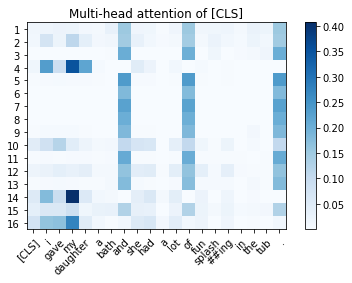

In [68]:
weights = np.array(weights)[:,0:len(input_tokens)-1]

fig, ax = plt.subplots()
im = ax.imshow(weights,cmap=plt.cm.Blues)
# We want to show all ticks...
ax.set_xticks(np.arange(len(input_tokens)-1))
ax.set_yticks(np.arange(16))
# ... and label them with the respective list entries
ax.set_xticklabels(input_tokens)
ax.set_yticklabels([i for i in range(1,17)])
plt.colorbar(im)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Multi-head attention of [CLS]")
fig.tight_layout()
plt.show()

In this visualization, x-axis is the key which attention is being paid, y-axis is number of layer. 

Color intensity reflects the attention weight. 


### Advanced visualization tool

We can use [`bertviz`](https://github.com/jessevig/bertviz) tool to visualize attention in BERT. It extends the [Tensor2Tensor](https://github.com/tensorflow/tensor2tensor/tree/master/tensor2tensor/visualization) visualization tool by Llion Jones and the `Transformers` library from HuggingFace.


Install and import related libraries.

In [45]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install regex

Cloning into 'bertviz_repo'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 1065 (delta 26), reused 37 (delta 16), pack-reused 1013
Receiving objects: 100% (1065/1065), 100.13 MiB | 20.55 MiB/s, done.
Resolving deltas: 100% (675/675), done.


In [0]:
from bertviz import head_view

In [0]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

Interactive visualization.

You can check the weights of each head of each layer interactively.

This view visualizes attention as lines connecting the word being updated (left) (i.e, key) with the word being attended to (right) (i.e., query), following the design of the figures above. Color intensity reflects the attention weight; weights close to one show as very dark lines, while weights close to zero appear as faint lines or are not visible at all. The user may highlight a particular word to see the attention from that word only. 

In [48]:
call_html()
# give attention weights and the list of tokens to head_view() function
head_view(attention_weights, input_tokens)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

With `BertViz`, we also can visualize attention in all of the heads at once, using the `model view', and visualize how attention weights are computed from query and key vectors using the `neuron view`.

`BertViz` also supports the visualization of other transformer-based models (e.g., BERT, GPT-2, XLNet, RoBERTa, and XLM). 

If you are interested in exploring this visualization tool please visit [`BertViz` repository](https://github.com/jessevig/bertviz). 

### References:
* http://mccormickml.com/2019/07/22/BERT-fine-tuning/
* https://huggingface.co/transformers/index.html
* https://colab.research.google.com/drive/1ywsvwO6thOVOrfagjjfuxEf6xVRxbUNO#scrollTo=_QXZhFb4LnV5
* https://github.com/google-research/bert
* https://towardsdatascience.com/deconstructing-bert-part-2-visualizing-the-inner-workings-of-attention-60a16d86b5c1